In [1]:
from pflow.particle_filter import BootstrapFilter, ObservationBase, FilterState, LikelihoodMethodBase, ProposalMethodBase
from pflow.optimal_transport.transportation_plan import Transport
from pflow.resampling.systematic import SystematicResampling

In [2]:
import pykalman

In [3]:
import torch

In [4]:
import numpy as np

In [504]:
class BrownianProposalMethod(ProposalMethodBase):
    def __init__(self, transition, lower_triang_chol):
        self.transition = transition
        locs = torch.zeros(lower_triang_chol.shape[0], requires_grad=False)
        self._dist = torch.distributions.MultivariateNormal(locs, scale_tril=lower_triang_chol)
        
    def apply(self, state, _observation):
        x = state.x
        sample = self._dist.rsample((x.shape[0],))
        x_proposed = ((self.transition @ state.x.T).T + sample)
        return FilterState(x=x_proposed, logw=state.logw, n=state.n, loglik=state.loglik)
    
class Observation(ObservationBase):
    __slots__ = ['y']
    def __init__(self, y):
        self.y = y
        
class LikelihoodMethod(LikelihoodMethodBase):
    def __init__(self, obs_matrix, obs_cov_triang):
        locs = torch.zeros(obs_cov_triang.shape[0], requires_grad=False)
        self._obs_matrix = obs_matrix
        self._dist = torch.distributions.MultivariateNormal(loc=locs, scale_tril=obs_cov_triang)
        
    def apply(self, state, observation, log=True):
        distance = (self._obs_matrix @ state.x.T).T - observation.y.unsqueeze(0)
        log_probs = self._dist.log_prob(distance)
        if log:
            return log_probs
        else:
            return log_probs.exp()
        

In [505]:
_ = torch.random.manual_seed(0)

In [506]:
import math
import random
random.seed(42)

In [507]:
def generate_sine(dt, seed=42):
    random.seed(seed)
    t = 0
    while True:
        yield math.sin(t) + (random.random()-0.5)/2., math.cos(t) + (random.random()-0.5)/2.
        t += dt

In [508]:
dt = 0.1
K = 100

sine_gen = generate_sine(dt)

def run_pf(flat, log_sigma, dt_init, seed=0):
    n = 200
    states = []
    observations = []
    
    torch.random.manual_seed(seed)
    
    initial_dist = torch.distributions.MultivariateNormal(torch.tensor([0., 0.]), scale_tril=torch.tensor([[1., 0.], [0., 1.]]))
    initial_x = initial_dist.rsample((n,)).clone()
    initial_x.requires_grad=True
    initial_w = torch.full((n,), 1/n, requires_grad=True)
    initial_log_lik = torch.tensor(0., requires_grad=True)
    
    lower = torch.zeros((2, 2), requires_grad=False)
    tril_indices = torch.tril_indices(row=2, col=2, offset=0)
    lower[tril_indices[0], tril_indices[1]] = flat
    
    transition_matrix = torch.tensor([[1., 0.], [0., 1.]])
    transition_matrix[0, 1] = dt_init
    transition_matrix[1, 0] = -dt_init

    sigma = log_sigma.exp()
    obs_triang = torch.eye(2, requires_grad=False) * sigma
    obs_matrix = torch.eye(2, requires_grad=False)
    state = FilterState(x=initial_x, logw=initial_w.log(), n=n, loglik=initial_log_lik)
    likelihood_method = LikelihoodMethod(obs_matrix, obs_triang)
    boot = BootstrapFilter(proposal_method=BrownianProposalMethod(transition_matrix, lower),
                           likelihood_method=likelihood_method, 
#                            reweighting_method=SystematicResampling(),
                           reweighting_method=Transport(epsilon=0.15, scaling=0.9),
                           min_neff=0.5)
    
    for i in range(K):
        obs = Observation(torch.tensor(next(sine_gen), requires_grad=False))

        state = boot.update(state, obs)
        observations.append(obs)
        states.append(state)
        
        state = boot.predict(state, None)
    return -state.loglik, states, observations

In [509]:
def get_kalman_lik(log_sigma, flat, data):
    lower = torch.zeros((2, 2), requires_grad=False)
    tril_indices = torch.tril_indices(row=2, col=2, offset=0)
    lower[tril_indices[0], tril_indices[1]] = flat
    
    kf = pykalman.KalmanFilter(observation_covariance=[[np.exp(-2), 0.], [0., np.exp(-2)]], transition_covariance=[[0.01, 0.], [0., 0.01]])

In [516]:
log_sigma = torch.tensor(-1., requires_grad=True)
flat = torch.tensor([0.1,0., 0.1], requires_grad=True)
dt_learn = torch.tensor(0., requires_grad=True)

In [517]:
rms = torch.optim.RMSprop(params=[dt_learn], lr=0.01)
for _ in range(10):
    rms.zero_grad()
    res = run_pf(flat, log_sigma, dt_learn)
    res[0].backward()
    rms.step()
    print(dt_learn)

tensor(0.1000, requires_grad=True)
tensor(0.1015, requires_grad=True)
tensor(0.0972, requires_grad=True)
tensor(0.1094, requires_grad=True)
tensor(0.0716, requires_grad=True)
tensor(0.1187, requires_grad=True)
tensor(0.0964, requires_grad=True)
tensor(0.1142, requires_grad=True)
tensor(0.1102, requires_grad=True)
tensor(0.0876, requires_grad=True)


In [518]:
observations = np.stack([l.y.detach().numpy() for l in res[2]], 0)

In [519]:
kf1 = pykalman.KalmanFilter(observation_covariance=[[np.exp(-2), 0.], [0., np.exp(-2)]], transition_covariance=[[0.01, 0.], [0., 0.01]])

In [520]:
kf2 = pykalman.KalmanFilter(observation_covariance=[[np.exp(-2), 0.], [0., np.exp(-2)]], transition_covariance=[[0.01, 0.], [0., 0.01]])

In [521]:
kf1.loglikelihood(observations)

-66.902743985198

In [522]:
(kf2.loglikelihood(observations) - kf1.loglikelihood(observations)) * 1e3

0.0

In [523]:
kf2.loglikelihood(observations), res[0]

(-66.902743985198, tensor(26.8823, grad_fn=<NegBackward>))

In [524]:
exact_filter = kf.filter(observations)

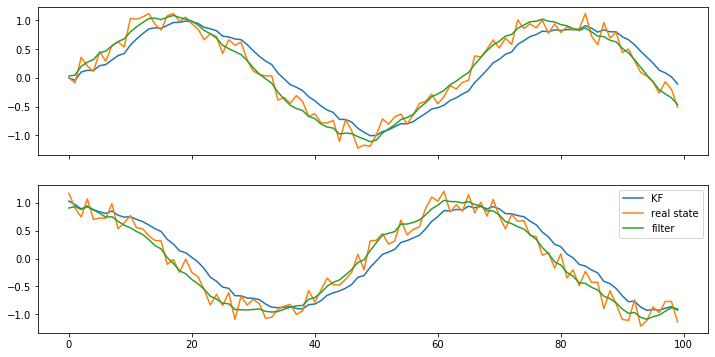

In [525]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 6), sharex=True)

axes[0].plot(exact_filter[0][:, 0].squeeze(), label='KF')
axes[0].plot([l.y[0].detach().numpy().mean() for l in res[2]], label = 'real state')
axes[0].plot([(l.x[:, 0] * l.w).detach().numpy().sum() for l in res[1]], label = 'filter')

axes[1].plot(exact_filter[0][:, 1].squeeze(), label='KF')
axes[1].plot([l.y[1].detach().numpy().mean() for l in res[2]], label = 'real state')
axes[1].plot([(l.x[:, 1] * l.w).detach().numpy().sum() for l in res[1]], label = 'filter')



_ = plt.legend()


In [461]:
kf.loglikelihood(observations), res[0]

(-69.43842299355744, tensor(-428.7426, grad_fn=<AddBackward0>))

In [314]:
torch.autograd.grad(res[0], [log_sigma])

RuntimeError: Trying to backward through the graph a second time, but the buffers have already been freed. Specify retain_graph=True when calling backward the first time.

In [124]:
def weighted_avg_and_var(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights, axis=0)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights, axis=0)
    return (average, variance)

In [125]:
weighted_avg_and_var(res[1][-2].x.detach().numpy(), res[1][-2].w.detach().numpy())

(array([ 0.24417213, -0.9354718 ], dtype=float32),
 array([0.02939471, 0.04896374], dtype=float32))

In [126]:
exact_filter[1][-2]

array([[0.03212617, 0.        ],
       [0.        , 0.03212617]])

In [129]:
exact_filter[0][-2]

array([0.27250963, 0.80522926])